In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import svm

#### 1. First clean: only take the useful columns

In [70]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [71]:
print round3.columns
print round2.columns
print round1.columns

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')
Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'host_acceptance_rate',
       u'host_id', u'host_is_superhost', u'ho

In [72]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [73]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean.head()

,id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,instant_bookable,room_type,bucket_name,discount_asked,nightly_price,decision,price_agreed,percent_agreed,calendars,price_requested
0,5557381,28811542,100%,100%,1,t,Private room,daysM_weeks1,0.7,51,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
1,9147025,403032,100%,100%,1,f,Entire home/apt,days1_weeksM,0.7,134,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",90
10,2745620,1172202,100%,100%,5,t,Private room,days3_weeks1,0.9,41,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35
100,7879486,38964485,100%,92%,2,f,Entire home/apt,days2_weeks1,0.7,101,-1,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",70
101,3557570,1594959,100%,None,1,f,Private room,daysM_weeks2,0.6,65,0,NaN,None,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",35


In [74]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [75]:
combined.head()

,bucket_name,calendars,decision,discount_agreed,discount_asked,host_acceptance_rate,host_id,host_response_rate,host_total_listings_count,id,instant_bookable,nightly_price,percent_agreed,price_agreed,price_requested,room_type,source
0,daysM_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.7,100%,28811542,100%,1,5557381,t,51,None,NaN,35,Private room,1
1,days1_weeksM,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,100%,403032,100%,1,9147025,f,134,None,NaN,90,Entire home/apt,1
2,days3_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.9,100%,1172202,100%,5,2745620,t,41,None,NaN,35,Private room,1
3,days2_weeks1,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",-1,NaN,0.7,92%,38964485,100%,2,7879486,f,101,None,NaN,70,Entire home/apt,1
4,daysM_weeks2,"{u'date': {u'24': u'2016-04-20', u'25': u'2016...",0,NaN,0.6,None,1594959,100%,1,3557570,f,65,None,NaN,35,Private room,1


In [76]:
combined.isnull().sum()

bucket_name                    0
calendars                      0
decision                       0
discount_agreed              705
discount_asked                 0
host_acceptance_rate          56
host_id                        0
host_response_rate            20
host_total_listings_count      0
id                             0
instant_bookable               0
nightly_price                  0
percent_agreed               703
price_agreed                 573
price_requested              283
room_type                      0
source                         0
dtype: int64

#### 2. Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [77]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [78]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [79]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [80]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 3. Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [81]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

In [82]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [83]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

#### 4. Process the decision variables:

Calculate the percentage of the discount agreed:

In [94]:
combined.groupby("decision")["id"].count()/len(combined)

decision
-1    0.471751
 0    0.316384
 1    0.211864
Name: id, dtype: float64

In [95]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

### Again, only keep the useful columns

In [96]:
combined.columns

Index([              u'bucket_name',                 u'calendars',
                        u'decision',           u'discount_agreed',
                  u'discount_asked',      u'host_acceptance_rate',
                         u'host_id',        u'host_response_rate',
       u'host_total_listings_count',                        u'id',
                u'instant_bookable',             u'nightly_price',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',              u'price_median',
                       u'price_std',          u'orig_percent_off',
                    u'occupancy_1m',                    u'shared',
                         u'instant',             u'response_rate',
                           u'orp_1',                     u'orp_2',
                           u'orp_3',                     u'adv_1',
                           u'adv_2',              u'orp_1, adv

In [97]:
combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [98]:
combined_clean.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
0,1,1,False,True,45,0.090351,0.433333,0,0,0,...,0,0,0,0,0,0.055556,0.7,0,0,1
1,1,1,False,False,106,0.144629,0.700000,1,0,0,...,0,0,0,0,0,0.000000,0.7,-1,0,1
2,5,1,False,True,46,0.021650,0.366667,0,0,1,...,0,0,0,1,0,0.108696,0.9,-1,0,1
3,2,1,False,False,120,0.095207,0.500000,0,1,0,...,0,1,0,0,0,0.246269,0.7,-1,0,1
4,1,1,False,True,65,0.000000,0.933333,0,0,0,...,0,0,0,0,0,0.000000,0.6,0,0,1


### Construct training samples

For studying whether hosts are negotiable, we exclude responses that do not indicate clearly whether the host accepts negotiations.

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

In [99]:
mask_available = combined_clean["decision"] != -1 
mask_agreed = combined_clean["decision"]== 1 
mask_no_source1 = combined_clean["source"] != 1

combined_available = combined_clean[mask_available]
combined_agreed = combined_clean[mask_agreed]

cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["orig_percent_off", "host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]
all_param = cal_param + host_param + ["discount_asked" ]
all_param_no_discount_asked = cal_param + host_param

X_train_negotiable = combined_available[all_param].values
X_train_negotiable_no_discount_asked = combined_available[all_param_no_discount_asked].values

Y_train_negotiable = combined_available["decision"].values

X_train_discount = combined_agreed[]
Y_train_discount = combined_agreed[mask_agreed]



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [102]:
mask1 = combined_clean["decision"]!=-1 
mask2 = combined_clean["source"]!=1
print mask1, mask2

0       True
1      False
2      False
3      False
4       True
5       True
6      False
7       True
8       True
9      False
10      True
11     False
12      True
13      True
14     False
15     False
16      True
17     False
18     False
19      True
20      True
21      True
22      True
23     False
24      True
25     False
26     False
27     False
28     False
29      True
       ...  
678    False
679     True
680    False
681    False
682    False
683    False
684     True
685    False
686     True
687     True
688    False
689    False
690     True
691     True
692    False
693    False
694    False
695    False
696     True
697    False
698    False
699    False
700    False
701     True
702    False
703    False
704     True
705    False
706    False
707    False
Name: decision, dtype: bool 0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     Fal

In [93]:
print len(combined_available)
combined_available.isnull().sum()

374


host_total_listings_count      0
response_rate                  0
instant                        0
shared                         0
price_median                   0
price_std                      0
occupancy_1m                   0
orp_1                          0
orp_2                          0
orp_3                          0
adv_1                          0
adv_2                          0
orp_1, adv_1                   0
orp_1, adv_2                   0
orp_2, adv_1                   0
orp_2, adv_2                   0
orp_3, adv_1                   0
orp_3, adv_2                   0
orig_percent_off               0
discount_asked                 0
decision                       0
discount_obtained            268
source                         0
dtype: int64

#### Logistic

In [282]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=10)

In [283]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.059035969950110227),
 ('orp_2', 0.34528542329210077),
 ('orp_3', 0.064086007519009155),
 ('adv_1', -0.08223985054410142),
 ('adv_2', 0.046105699144746028),
 ('orp_1, adv_1', -0.49652524058797903),
 ('orp_1, adv_2', 0.84921926845429174),
 ('orp_2, adv_1', 0.2592240657629723),
 ('orp_2, adv_2', 0.17764837994945465),
 ('orp_3, adv_1', -0.51284592179090305),
 ('orp_3, adv_2', 0.081611159242060499),
 ('host_total_listings_count', 0.10738962095861969),
 ('response_rate', -0.46272900306040138),
 ('instant', 0.0),
 ('shared', -0.3556813441408837),
 ('price_median', 0.0021273199467591601),
 ('price_std', -0.012283875579207999),
 ('occupancy_1m', -0.45875361081276017)]

In [284]:
print logistic.score(X_train, Y_train)
print lr_scores

0.652777777778
[ 0.6         0.53333333  0.4         0.46666667  0.42857143  0.42857143
  0.5         0.64285714  0.14285714  0.57142857]


#### Random Forest

In [285]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [286]:
print rf.score(X_train, Y_train)
print rf_scores

0.839861875
[ 0.26298276  0.30393103  0.26946897  0.35293448  0.28610714]


Feature ranking:
1. price_median (feature 15, importance: 0.185904)
2. occupancy_1m (feature 17, importance: 0.176558)
3. price_std (feature 16, importance: 0.168804)
4. response_rate (feature 12, importance: 0.136223)
5. host_total_listings_count (feature 11, importance: 0.102048)
6. shared (feature 14, importance: 0.040190)
7. adv_2 (feature 4, importance: 0.026955)
8. adv_1 (feature 3, importance: 0.025338)
9. orp_2 (feature 1, importance: 0.025320)
10. orp_1 (feature 0, importance: 0.018704)
11. orp_1, adv_2 (feature 6, importance: 0.018313)
12. orp_3 (feature 2, importance: 0.018081)
13. orp_2, adv_2 (feature 8, importance: 0.015674)
14. orp_2, adv_1 (feature 7, importance: 0.013345)
15. orp_3, adv_1 (feature 9, importance: 0.012477)
16. orp_3, adv_2 (feature 10, importance: 0.008718)
17. orp_1, adv_1 (feature 5, importance: 0.007349)
18. instant (feature 13, importance: 0.000000)


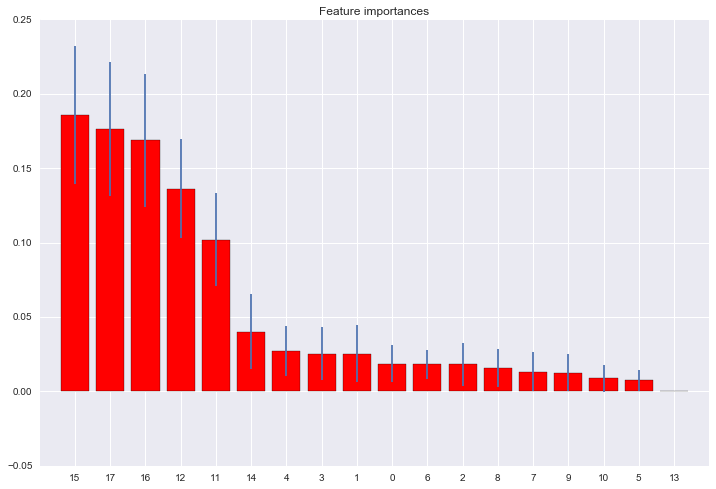

In [290]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# # Build a classification task using 3 informative features
# X_train, Y_train = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

forest.fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (feature %d, importance: %f)" % (f + 1, all_param[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [108]:
available= pd.merge(responses[responses["availability"]!=-1], inside_airbnb, how='inner',left_on=['id'], right_on=['id'])

In [109]:
sample_count = available.groupby("bucket_name")["id"].count()
print len(available)
print sample_count

104
bucket_name
days1_weeks1    10
days1_weeksM     9
days2_weeks1     9
days2_weeks2    12
days2_weeksM    10
days3_weeks1    11
days3_weeks2     5
days3_weeksM     9
daysM_weeks1    10
daysM_weeks2     9
daysM_weeksM    10
Name: id, dtype: int64


In [110]:
cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
all_param = cal_param + ["discount_asked", "nightly_price", "shared", "instant"]

In [111]:
X_train = available[all_param].values
Y_train = available["availability"].values

## Logistic Regression

In [112]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=5)

#### Coefficient

In [113]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.67978310106545903),
 ('orp_2', 0.44899177569948689),
 ('orp_3', 0.48967858479423343),
 ('adv_1', -0.50649697324094611),
 ('adv_2', -0.45148027073001312),
 ('orp_1, adv_1', 0.2947336720609543),
 ('orp_1, adv_2', 0.0),
 ('orp_2, adv_1', -0.069988895069940132),
 ('orp_2, adv_2', 0.43221886011959287),
 ('orp_3, adv_1', -0.04378944953693914),
 ('orp_3, adv_2', 0.41504606143040967),
 ('discount_asked', -0.24696961430142622),
 ('nightly_price', 0.0044412580210620861),
 ('shared', 0.036177417352815128),
 ('instant', 0.0)]

#### Accuracy

In [114]:
logistic.score(X_train, Y_train)

0.69230769230769229

In [115]:
lr_scores

array([ 0.36363636,  0.72727273,  0.55      ,  0.4       ,  0.3       ])

#### Prediction

In [116]:
logistic.predict_proba(X_train)[:5]

array([[ 0.82316984,  0.17683016],
       [ 0.84021617,  0.15978383],
       [ 0.83849245,  0.16150755],
       [ 0.84180909,  0.15819091],
       [ 0.830444  ,  0.169556  ]])

## Random Forest

In [146]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [147]:
rf.score(X_train, Y_train)

0.84335812827753132

In [148]:
rf_scores

array([ 0.16735238,  0.23689048,  0.24374762,  0.26832857,  0.28012   ])

In [149]:
rf.predict(X_train)

array([ 0.07,  0.02,  0.  ,  0.16,  0.  ,  0.1 ,  0.74,  0.17,  0.75,
        0.06,  0.02,  0.69,  0.18,  0.05,  0.19,  0.13,  0.15,  0.17,
        0.08,  0.18,  0.04,  0.04,  0.07,  0.01,  0.68,  0.93,  0.11,
        0.93,  0.69,  0.12,  0.26,  0.68,  0.13,  0.31,  0.75,  0.19,
        0.94,  0.85,  0.76,  0.19,  0.13,  0.76,  0.97,  0.85,  0.21,
        0.05,  0.92,  0.92,  0.09,  0.04,  0.28,  0.03,  0.81,  0.08,
        0.05,  0.77,  0.75,  0.3 ,  0.67,  0.03,  0.08,  0.72,  0.8 ,
        0.83,  0.21,  0.19,  0.79,  0.09,  0.69,  0.21,  0.13,  0.26,
        0.74,  0.83,  0.66,  0.65,  0.09,  0.04,  0.09,  0.15,  0.04,
        0.35,  0.24,  0.03,  0.7 ,  0.16,  0.09,  0.68,  0.02,  0.08,
        0.1 ,  0.13,  0.13,  0.13,  0.24,  0.75,  0.68,  0.2 ,  0.06,
        0.74,  0.21,  0.71,  0.73,  0.09])

## SVM

In [134]:
clf = svm.SVC()
clf.fit(X_train, Y_train)  

clf_scores = -cross_val_score(clf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [135]:
clf.score(X_train, Y_train)

0.82692307692307687

In [136]:
clf_scores

array([ 0.45454545,  0.36363636,  0.4       ,  0.25      ,  0.35      ])

In [137]:
clf.support_vectors_

array([[   1.,    0.,    0., ...,   65.,    1.,    0.],
       [   1.,    0.,    0., ...,   32.,    1.,    0.],
       [   1.,    0.,    0., ...,   48.,    1.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  283.,    0.,    0.],
       [   0.,    0.,    0., ...,   69.,    1.,    0.],
       [   0.,    0.,    0., ...,   72.,    1.,    0.]])